<a href="https://colab.research.google.com/github/daisysong76/AI--Machine--learning/blob/main/Xiaomei_causal_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Causal Inference Workshop

Hands-on Workshops by Xiaomei Song

---
- [`doWhy` GitHub repo](https://github.com/Microsoft/dowhy)
- [`doWhy` document](https://causalinference.gitlab.io/dowhy/)


## Before running all cells, please go to `FILE > Save a copy in Drive` to save the colab notebook to your own Google Drive.

### [0.1] Install dependencies


We recommend you to use VM provided by Google colab due to package version compatibility. It may take a minute to initialize the VM and install the following dependencies and packages.


In [1]:
%%capture
!git clone https://github.com/Microsoft/dowhy.git
!sudo apt install graphviz libgraphviz-dev graphviz-dev pkg-config
!pip install pygraphviz \
 --install-option="--include-path=/usr/include/graphviz" \
 --install-option="--library-path=/usr/lib/graphviz/"
!pip install -r ./dowhy/requirements.txt
!pip install --upgrade pandas
!pip install --upgrade statsmodels
!python ./dowhy/setup.py install
!wget -P ./dowhy/dowhy/causal_estimators/ \
https://raw.githubusercontent.com/ckbjimmy/2019_tokyo/master/supp/logistic_regression_estimator.py

### Reload the updated packages by manually running `Runtime > Restart runtime` or `Ctrl + M .`

Make sure that you do this.

![runtime](https://raw.githubusercontent.com/ckbjimmy/2019_tokyo/master/supp/runtime.png =600x)

### [0.2] Load packages

In [ ]:
import sys
sys.path.append('dowhy')
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from scipy import stats
from IPython.display import Image, display

from dowhy.do_why import CausalModel
import dowhy.datasets
from sklearn.linear_model import LogisticRegression

### [0.3] Create a data simulator and define a graph

In [ ]:
class DataSimulator(object):
    def __init__(self):
        # Specify the model parameters
        self.sample_size = 5000

        # Specify the prevalence of A (exposure)
        self.p_A = 0.2

        self.a_0 = np.log(0.05/(1 - 0.05))
        self.a_LA = np.log(10.0)

        # Parameters for the odds of Y (outcome)
        self.y_0 = np.log(0.05/(1 - 0.05)) # log odds of Y for ref group (A = 0, L = 0, and S = 0)
        self.y_AY = np.log(1.0) # log OR for effect of A on log odds of Y (OR = 1.0) no effect
        self.y_LY = np.log(5.0) # log OR for effect of L on log odds of Y (OR = 5.0)

        # Parameters for the odds of S (selection)
        self.s_0 = np.log(0.10/(1 - 0.10)) # log odds of S for ref group (A = 0 and L = 0)
        self.s_AS = np.log(5.0) # log OR for effect of A on log odds of selection (OR = 5.0)
        self.s_LS = np.log(5.0) # log OR for effect of L on log odds of selection (OR = 5.0)
        self.s_LA = np.log(1.0) # log OR for interaction between A and L (OR = 1.0)

    def prob_A(self, L):
        return np.exp(self.a_0 + self.a_LA*L)/(1 + np.exp(self.a_0 + self.a_LA*L))

    def prob_S(self, A, L):
        return np.exp(self.s_0 + self.s_AS*A + self.s_LS*L + self.s_LA*L*A) / (1 + np.exp(self.s_0 + self.s_AS*A + self.s_LS*L + self.s_LA*L*A))

    def prob_Y(self, A, L):
        return np.exp(self.y_0 + self.y_AY*A +  self.y_LY*L) / (1 + np.exp(self.y_0 + self.y_AY*A +  self.y_LY*L))

    def get_graph(self, task):
        if task == 'confounder':
            g = '''
            graph [
            directed 1
            node[id "A" label "A"]
            node[id "Y" label "Y"]
            node[id "L" label "L"]
            edge[source "L" target "A" weight 1]
            edge[source "L" target "Y" weight 1]
            ]
            '''

            d = '''
            digraph {
            L -> A;
            L -> Y;
            }
            '''

        elif task == 'collider':
            g = '''
            graph [
            directed 1
            node[id "A" label "A"]
            node[id "Y" label "Y"]
            node[id "S" label "S"]
            node[id "L" label "L"]
            edge[source "A" target "S" weight 1]
            edge[source "L" target "A" weight 1]
            edge[source "L" target "Y" weight 1]
            edge[source "L" target "S" weight 1]
            ]
            '''

            d = '''
            digraph {
            A -> S;
            L -> A;
            L -> Y;
            L -> S;
            }
            '''

        return g, d

    def get_data(self, task):
        np.random.seed(777)
        g, d = self.get_graph(task)

        if task == 'confounder':
            ls_L = stats.norm.rvs(size=self.sample_size, loc=0, scale=1)
            p_A = [self.prob_A(ls_L[i]) for i in range(self.sample_size)]
            r = stats.uniform.rvs(size=self.sample_size, loc=0, scale=1)
            ls_A = [1 if p_A[i] > r[i] else 0 for i in range(len(p_A))]
            p_Y = [self.prob_Y(ls_A[i], ls_L[i]) for i in range(self.sample_size)]
            r = stats.uniform.rvs(size=self.sample_size, loc=0, scale=1)
            ls_Y = [1 if p_Y[i] > r[i] else 0 for i in range(len(p_Y))]
            return pd.DataFrame({
                'L': ls_L,
                'A': ls_A,
                'prob_A': p_A,
                'Y': ls_Y,
                'prob_Y': p_Y
            }, columns=['L', 'A', 'prob_A', 'Y', 'prob_Y']), g, d

        if task == 'collider':
            ls_A = stats.binom.rvs(size=self.sample_size, n=1, p=self.p_A)
            ls_L = stats.norm.rvs(size=self.sample_size, loc=0, scale=1)
            p_S = [self.prob_S(ls_A[i], ls_L[i]) for i in range(self.sample_size)]
            p_Y = [self.prob_Y(ls_A[i], ls_L[i]) for i in range(self.sample_size)]
            return pd.DataFrame({
                'L': ls_L,
                'A': ls_A,
                'S': stats.binom.rvs(size=self.sample_size, n=1, p=p_S),
                'prob_S': p_S,
                'Y': stats.binom.rvs(size=self.sample_size, n=1, p=p_Y),
                'prob_Y': p_Y
            }, columns=['L', 'A', 'S', 'prob_S', 'Y', 'prob_Y']), g, d


### In the lecture part, we learned the basic concept of DAG.
- DAG is a very useful tool to identify the relationship among variables.
- DAG enables you to find what will happen if you condition on variables.
  - If you condition on a confounder, you can close a backdoor path.
  - if you condition on a collider, you will open a backdoor path.
  - This helps you how to ditiguish "association" and "effect"
   
### The goal of this hands on is to quantify confounding and selection bias.
- We use simulated data, otherwise we cannot qunatify the magnitude of bias.
- We will give our simulated data one example context to make it easily understood.
  - Study period: 1972 to 1992
  - Population: 5000 cigarette smokers
  - Treatment =  A:  quit smoking during 1972 to 1975
    - A=1 : yes
    - A=0 : no  
  - Outcome = Y : death by 1992
    - Y=1 : yes
    - Y=0 : no
  - Confounder = L : age at baseline
    - continuous radndome variable ~N(  ,   )
  - Collider/Censoring = S : death by 1992 is missing
    - Y=1 : yes
    - Y=0 : no

### Let's say, we will work on one observational research. The aim of this research is to estimate the averge treatment effect of smoking cessation on death. Our effect measure is odds ratio. Through estimating the odds of death comparing treatment group (A=1) to non-treatment group (A =0) over the study period from the simulated data with statistical models, we will estimate our estimand (the average treatment effect)

---
### The goal of this hands-on is to quantify confounding and selection bias. Before getting into our coding practice, please let me do a quick lecture about "Counterfactual Model for Causal Inference"

![lec1](https://raw.githubusercontent.com/ckbjimmy/2019_tokyo/master/supp/lec1.png =800x)

<br>
***
<br>

![lec2](https://raw.githubusercontent.com/ckbjimmy/2019_tokyo/master/supp/lec2.png =800x)

<br>
***
<br>

![lec3](https://raw.githubusercontent.com/ckbjimmy/2019_tokyo/master/supp/lec3.png =800x)

<br>
***
<br>

![lec4](https://raw.githubusercontent.com/ckbjimmy/2019_tokyo/master/supp/lec4.png =800x)

<br>
***
<br>

![lec5](https://raw.githubusercontent.com/ckbjimmy/2019_tokyo/master/supp/lec5.png =800x)

<br>
***
<br>

![lec6](https://raw.githubusercontent.com/ckbjimmy/2019_tokyo/master/supp/lec6.png =800x)

<br>
***
<br>

![lec7](https://raw.githubusercontent.com/ckbjimmy/2019_tokyo/master/supp/lec7.png =800x)


## 1. Confounding bias

### [1.1] Load and inspect data

First, we simulate some data where a treatment (A) has no effect on an outcome (Y). And we create one more continuous variable age (L)

In [ ]:
task = 'confounder'

sim = DataSimulator()
data = {}
data['df'], g, d = sim.get_data(task)
data['treatment_name'] = 'A'
data['outcome_name'] = 'Y'
data['gml_graph'] = g.replace('\n', '')
data['dot_graph'] = d.replace('\n', '')

In [ ]:
data

{'df':              L  A    prob_A  Y    prob_Y
 0    -0.468209  0  0.017593  0  0.024174
 1    -0.822825  0  0.007852  0  0.013806
 2    -0.065380  0  0.043315  0  0.045232
 3    -0.713362  0  0.010081  0  0.016422
 4     0.906351  0  0.297864  0  0.184564
 5     0.766237  0  0.235032  0  0.153004
 6     0.826054  1  0.260691  0  0.165902
 7    -1.323683  0  0.002492  0  0.006213
 8    -1.752445  0  0.000930  0  0.003126
 9     1.002449  0  0.346103  0  0.208984
 10    0.544809  0  0.155780  0  0.112286
 11    1.895161  1  0.805233  1  0.526402
 12   -0.769357  0  0.008872  0  0.015028
 13   -1.403096  0  0.002076  0  0.005472
 14   -0.632468  0  0.012119  0  0.018663
 15   -0.558874  0  0.014325  0  0.020961
 16   -1.233231  0  0.003067  0  0.007180
 17   -0.439504  0  0.018772  0  0.025288
 18    0.914787  0  0.301943  0  0.186617
 19    0.265041  1  0.088333  0  0.074615
 20   -1.383370  0  0.002172  0  0.005647
 21    0.685512  1  0.203269  0  0.136915
 22    0.456091  1  0.130761

In [ ]:
data['df'].describe()

L           A       prob_A            Y       prob_Y
count  5000.000000  5000.00000  5000.000000  5000.000000  5000.000000
mean      0.011264     0.16280     0.157455     0.117200     0.109711
std       1.005935     0.36922     0.226192     0.321691     0.147397
min      -4.179179     0.00000     0.000003     0.000000     0.000063
25%      -0.649716     0.00000     0.011653     0.000000     0.018162
50%       0.008526     0.00000     0.050941     0.000000     0.050656
75%       0.676582     0.00000     0.199959     0.000000     0.135226
max       4.270708     1.00000     0.998982     1.000000     0.980716

### [1.2] Ignore the presence of confounder

Here, we think there is no confouder. We put only the treatment in our logitstic regression model.

In [ ]:
df = data['df']
model = LogisticRegression(solver='lbfgs')
result = model.fit(df[['A']], df['Y']) # not conditioning on the confounder L
result.coef_

array([[1.79758921]])

We got the estimated regression coefficient of treatment 1.80, which means the estimated odds ratio ($\hat{OR}$) of death comparing the treatment group(A=1) to the non-treatment group (A=0) over the study period  is $\exp(1.80) = 6.05$. This doesn't match what we simulated. The $\hat{OR}$  should be close to 1.  We are looking at the confounding bias here.

### [1.3]
From now we will follow 3 steps. Through following these steps, we can avoid esimating the average treatment effecte with bias.


- Step 1 - Create a causal DAG  based on your expert knowledge
- Step 2 - Identification -> assessing Identifiability
- Step 3 - Estimate the average treatment effect from your observed data by statistical models.

Step 1 - Create a causal DAG from your expert knowledge. Then we identify confounders.

### By using DAG, we find that age (L) can confound the association between smoking cessation and death. In other words, we can assume age (L) is a confounder of the association between A and Y.


['L']
yes
{'observed': 'yes'}
Model to find the causal effect of treatment A on outcome Y


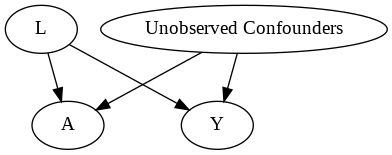

In [ ]:
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

model.view_model()
display(Image(filename="causal_model.png"))

Step 2 - Identification -> assessing Identifiability
   - Identifiability is the condition for identification, where (conditional) exchangenability, consistency, and positivity assumption are valid. Then, the average treatment effect in counterfactual model can be estimated as the quantities that are estimated by applying statistical models to your data.
  - This hands on section does not have enough time to explain why we need identification process.
  
### In this hands on session, we only focus on conditional exhangenability.  And we can assume conditional exchangenability holds when we condition on age (L). Thus, we think that the average treatment effect can be estimated as the odds ratio of death (Y) comparing treatment group (A=1) to non-treatment group (A=0) ovar the study period  conditional on age (L) .

In [ ]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'U', 'L'}


{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|L))
dA                  
Estimand assumption 1, Unconfoundedness: If U→A and U→Y then P(Y|A,L,U) = P(Y|A,L)
### Estimand : 2
Estimand name: iv
No such variable found!



Step 3 - Estimate the average treatment effec of A on Y with statistical models.
We choose a logistic regression model in this case. You may change the method to `backdoor.linear_regression` if your outcome is a continuous variable.

In [ ]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.logistic_regression")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Logistic Regression Estimator
INFO:dowhy.causal_estimator:b: Y~A+L


LogisticRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|L))
dA                  
Estimand assumption 1, Unconfoundedness: If U→A and U→Y then P(Y|A,L,U) = P(Y|A,L)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~A+L
## Estimate
Value: 0.10146292584442974

Causal Estimate is 0.10146292584442974


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Here we find that the estimate of the regression coefficient is 0.10 after conditioning on the confounder (L), which means the OR^ of Y comparing A=1 to A=0 with conditioning on  L is very close to 1 (no effect). This result matchs to what we expected. The $\hat{OR}$ is the estmate of the avearge treatment effect of A on Y.

Of course, we can get the same result without using `doWhy` library.

In [ ]:
df = data['df']
model = LogisticRegression() # adjusting the confounder L
result = model.fit(df[['A', 'L']], df['Y'])
result.coef_

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[0.10146293, 1.49088619]])

## 2. Selection bias

### [2.1] Load and inspect data

Next, we consider selection bias. Again, we start from data simulation. The simulation generates data in which the treatment (A) has no effect on the outcome (Y) but has the effect on a collider (S). In this part, age (L) has both the effect on the outcome and the effect on the collider, but not on the treatment.

  - Study period: 1972 to 1992
  - Population: 5000 cigarette smokers
  - Treatment =  A:  quit smoking during 1972 to 1975
    - A=1 : yes
    - A=0 : no  
  - Outcome = Y : death by 1992
    - Y=1 : yes
    - Y=0 : no
  - Variable = L : age at baseline
    - continuous radndome variable ~N(  ,   )
  - Collider/Censoring = S : death by 1992 is missing
    - Y=1 : yes
    - Y=0 : no

In [ ]:
task = 'collider'

sim = DataSimulator()
data = {}
data['df'], g, d = sim.get_data(task)
data['treatment_name'] = 'A'
data['outcome_name'] = 'Y'
data['gml_graph'] = g.replace('\n', '')
data['dot_graph'] = d.replace('\n', '')

In [ ]:
data

{'df':              L  A  S    prob_S  Y    prob_Y
 0    -0.960179  0  0  0.023145  0  0.011098
 1    -0.656002  0  0  0.037219  0  0.017982
 2     1.830391  0  0  0.678890  1  0.500366
 3     1.280116  0  1  0.465814  0  0.292314
 4     0.997199  1  1  0.734416  0  0.207591
 5     0.744937  1  1  0.648202  1  0.148615
 6     0.797930  0  0  0.286385  0  0.159732
 7    -0.777192  0  0  0.030827  0  0.014843
 8    -0.839310  0  0  0.027976  0  0.013450
 9     0.315866  0  0  0.155926  1  0.080463
 10    0.441038  0  1  0.184312  0  0.096685
 11   -0.780473  0  0  0.030669  0  0.014766
 12    0.027689  0  0  0.104083  0  0.052160
 13    0.738012  0  1  0.267090  0  0.147210
 14   -0.246299  1  0  0.272061  0  0.034196
 15   -1.108701  0  0  0.018314  0  0.008759
 16   -0.018315  0  0  0.097378  0  0.048618
 17    0.844254  0  0  0.301861  0  0.169995
 18    0.299237  0  0  0.152436  0  0.078505
 19   -0.652545  0  0  0.037418  0  0.018081
 20   -0.423308  0  0  0.053226  0  0.025939
 21 

In [ ]:
data['df'].describe()

L            A            S       prob_S            Y  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.007029     0.195200     0.224400     0.222725     0.113600   
std       1.006872     0.396394     0.417228     0.232482     0.317357   
min      -4.179179     0.000000     0.000000     0.000133     0.000000   
25%      -0.669800     0.000000     0.000000     0.043864     0.000000   
50%      -0.009911     0.000000     0.000000     0.129043     0.000000   
75%       0.700925     0.000000     0.000000     0.336197     0.000000   
max       3.399006     1.000000     1.000000     0.992480     1.000000   

            prob_Y  
count  5000.000000  
mean      0.109269  
std       0.145197  
min       0.000063  
25%       0.017594  
50%       0.049248  
75%       0.139873  
max       0.925948

### [2.2] Conditioning on the collider (S) induces selection bias

This time, we erroneously condition on the collider by restriciting our samples with S==0, which means our outcome has no missing (Complete case analysis).Then We will find selection bias arises as the consequence of conditioning on the collider (S).

In [ ]:
df = data['df']
df = df[df['S'] == 0]  #restriciting our samples with S==0 -> no missing in the outcome
model = LogisticRegression(solver='lbfgs')
result = model.fit(df[['A']], df['Y'])
result.coef_

array([[-0.34343617]])

We get the estimated regression coefficient -0.343, i.e. the estimated odds ratio of Y comparing A=1 to A=0 is $\exp(-0.343) = 0.709$. This is not what we expected because our expectation is no effect of the exposure on the outcome (the $\hat{OR}$ should be close to 1).

### [2.3] Consider causal graph

- Step 1 - Create a causal DAG  based on your expert knowledge
- Step 2 - Identification -> assessing Identifiability
- Step 3 - Estimate from data by statistical models

We want to mention that even though there is an arrow from the confounder to the treatment, there is no effect between them since the coefficient in the simulator is set to be $\log(1.0) = 0$. (Dowhy library does not allow us to create DAG without confounders)

Step 1 - Create a causal DAG from your expert knowledge. We identify  S  as the collider.

['L']
yes
{'observed': 'yes'}
Model to find the causal effect of treatment A on outcome Y


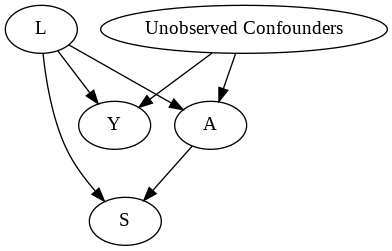

In [ ]:
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

model.view_model()
display(Image(filename="causal_model.png"))

Here, we find S is the collider of A and Y. To avoid causing selection bias, We should not restrict our patient without missing (S==0). If we did, we would get the biased result like we did in the last part.




- Step 2 - Identification -> assessing Identifiability

    - In this case, thre are no confouders. Thus we do not need to condition on confouders. Exhangenability assumption is expected to hold like in Rondamized Contrl Trial.

In [ ]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'U', 'L'}


{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|L))
dA                  
Estimand assumption 1, Unconfoundedness: If U→A and U→Y then P(Y|A,L,U) = P(Y|A,L)
### Estimand : 2
Estimand name: iv
No such variable found!



- Step 3 - Estimate the average treatment effect from your observed data by statistical models

In [ ]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.logistic_regression")

print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Logistic Regression Estimator
INFO:dowhy.causal_estimator:b: Y~A+L


LogisticRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|L))
dA                  
Estimand assumption 1, Unconfoundedness: If U→A and U→Y then P(Y|A,L,U) = P(Y|A,L)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~A+L
## Estimate
Value: 0.06435684610388824

Causal Estimate is 0.06435684610388824


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Here we find that the estimate of regression coefficient of A is 0.06 (the estimated odds ratio is very close to 1) when we do not condition on the collider (S) (not restricting our sample with S=0)

Again, we can get the very similar result without using `doWhy` library.

In [ ]:
df = data['df']
model = LogisticRegression()
result = model.fit(df[['A']], df[['Y']])
result.coef_

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[0.07009847]])

By resticting our subjects without missing value of outcome , the selection biase arise. Do you have any idea of how to deal with this?

## 3.(Extra) Hands-on exercise: NHEFS data

If we have extrat time, let's play with NHEFS data. The aim of this session/research is to quantifying the effect of quit smoking on the weight gain over the study period. Please follow the 3 steps we have learned through this workshop.

- Step 1 - Create a causal DAG  based on your expert knowledge
- Step 2 - Identification -> assessing Identifiability
- Step 3 - Estimate from data by statistical models



In [ ]:
nhefs = pd.ExcelFile('https://www.dropbox.com/s/nchp1pezska7bim/nhefs.xlsx?dl=1').parse('2017')
nhefs.columns

Index(['seqn', 'qsmk', 'death', 'yrdth', 'modth', 'dadth', 'sbp', 'dbp', 'sex',
       'age', 'race', 'income', 'marital', 'school', 'education', 'ht', 'wt71',
       'wt82', 'wt82_71', 'birthplace', 'smokeintensity', 'smkintensity82_71',
       'smokeyrs', 'asthma', 'bronch', 'tb', 'hf', 'hbp', 'pepticulcer',
       'colitis', 'hepatitis', 'chroniccough', 'hayfever', 'diabetes', 'polio',
       'tumor', 'nervousbreak', 'alcoholpy', 'alcoholfreq', 'alcoholtype',
       'alcoholhowmuch', 'pica', 'headache', 'otherpain', 'weakheart',
       'allergies', 'nerves', 'lackpep', 'hbpmed', 'boweltrouble', 'wtloss',
       'infection', 'active', 'exercise', 'birthcontrol', 'pregnancies',
       'cholesterol', 'hightax82', 'price71', 'price82', 'tax71', 'tax82',
       'price71_82', 'tax71_82'],
      dtype='object')

In [ ]:
nhefs.head(5)

seqn  qsmk  death  yrdth  modth  dadth    sbp   dbp  sex  age  race  \
0   233     0      0    NaN    NaN    NaN  175.0  96.0    0   42     1   
1   235     0      0    NaN    NaN    NaN  123.0  80.0    0   36     0   
2   244     0      0    NaN    NaN    NaN  115.0  75.0    1   56     1   
3   245     0      1   85.0    2.0   14.0  148.0  78.0    0   68     1   
4   252     0      0    NaN    NaN    NaN  118.0  77.0    0   40     0   

   income  marital  school  education        ht   wt71       wt82    wt82_71  \
0    19.0        2       7          1  174.1875  79.04  68.946040 -10.093960   
1    18.0        2       9          2  159.3750  58.63  61.234970   2.604970   
2    15.0        3      11          2  168.5000  56.81  66.224486   9.414486   
3    15.0        3       5          1  170.1875  59.42  64.410117   4.990117   
4    18.0        2      11          2  181.8750  87.09  92.079251   4.989251   

   birthplace  smokeintensity  smkintensity82_71  smokeyrs  asthma  bronch  \
0        47.0              30                -10        29       0       0   
1        42.0              20                -10        24       0       0   
2        51.0              20                -14        26       0       0   
3        37.0               3                  4        53       0       0   
4        42.0              20                  0        19       0       0   

   tb  hf  hbp  pepticulcer  colitis  hepatitis  chroniccough  hayfever  \
0   0   0    1            1        0          0             0         0   
1   0   0    0            0        0          0             0         0   
2   0   0    0            0        0          0             0         1   
3   0   0    1            0        0          0             0         0   
4   0   0    0            0        0          0             0         0   

   diabetes  polio  tumor  nervousbreak  alcoholpy  alcoholfreq  alcoholtype  \
0         1      0      0             0          1            1            3   
1         0      0      0             0          1            0            1   
2         0      0      1             0          1            3            4   
3         0      0      0             0          1            2            3   
4         0      0      0             0          1            2            1   

   alcoholhowmuch  pica  headache  otherpain  weakheart  allergies  nerves  \
0             7.0     0         1          0          0          0       0   
1             4.0     0         1          0          0          0       0   
2             NaN     0         1          1          0          0       1   
3             4.0     0         0          1          1          0       0   
4             2.0     0         1          0          0          0       0   

   lackpep  hbpmed  boweltrouble  wtloss  infection  active  exercise  \
0        0       1             0       0          0       0         2   
1        0       0             0       0          1       0         0   
2        0       0             0       0          0       0         2   
3        0       0             0       0          0       1         2   
4        0       0             1       0          0       1         1   

   birthcontrol  pregnancies  cholesterol  hightax82   price71   price82  \
0             2          NaN        197.0        0.0  2.183594  1.739990   
1             2          NaN        301.0        0.0  2.346680  1.797363   
2             0          2.0        157.0        0.0  1.569580  1.513428   
3             2          NaN        174.0        0.0  1.506592  1.451904   
4             2          NaN        216.0        0.0  2.346680  1.797363   

      tax71     tax82  price71_82  tax71_82  
0  1.102295  0.461975    0.443787  0.640381  
1  1.364990  0.571899    0.549316  0.792969  
2  0.551270  0.230988    0.056198  0.320251  
3  0.524902  0.219971    0.054794  0.304993  
4  1.364990  0.571899    0.549316  0.792969

['diabetes', 'age']
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
Model to find the causal effect of treatment qsmk on outcome wt82_71


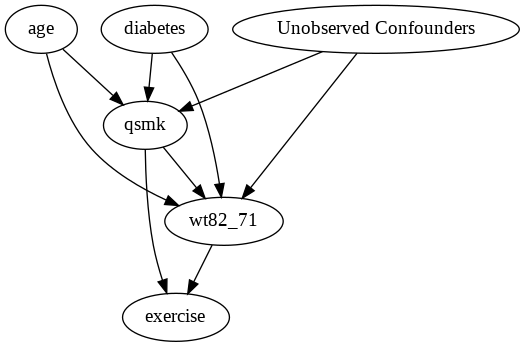

In [ ]:
g = '''
graph [
directed 1
node[id "qsmk" label "qsmk"]
node[id "wt82_71" label "wt82_71"]
node[id "age" label "age"]
node[id "diabetes" label "diabetes"]
node[id "exercise" label "exercise"]
edge[source "qsmk" target "wt82_71" weight 1]
edge[source "qsmk" target "exercise" weight 1]
edge[source "wt82_71" target "exercise" weight 1]
edge[source "age" target "qsmk" weight 1]
edge[source "age" target "wt82_71" weight 1]
edge[source "diabetes" target "qsmk" weight 1]
edge[source "diabetes" target "wt82_71" weight 1]
]
'''

d = '''
digraph {
qsmk -> wt82_71;
qsmk -> exercise;
age -> qsmk;
age -> wt82_71;
diabetes -> qsmk;
diabetes -> wt82_71;
wt82_71 -> exercise;
U[label="Unobserved Confounders"];
U -> qsmk;
U -> wt82_71;
}
'''

selected = ['age', 'diabetes', 'qsmk', 'wt82_71', 'exercise']

data = {}
data['df'] = nhefs[selected]
data['treatment_name'] = 'qsmk'
data['outcome_name'] = 'wt82_71'
data['gml_graph'] = g.replace('\n', '')
data['dot_graph'] = d.replace('\n', '')

model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

model.view_model()
display(Image(filename="causal_model.png"))

In [ ]:
identified_estimand = model.identify_effect()
print(identified_estimand)

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True)

print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'diabetes', 'U', 'age'}


{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: wt82_71~qsmk+diabetes+age


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                     
─────(Expectation(wt82_71|diabetes,age))
dqsmk                                   
Estimand assumption 1, Unconfoundedness: If U→qsmk and U→wt82_71 then P(wt82_71|qsmk,diabetes,age,U) = P(wt82_71|qsmk,diabetes,age)
### Estimand : 2
Estimand name: iv
No such variable found!

LinearRegressionEstimator


ValueError: ignored

In [ ]:
nhefs[selected].isnull().values.any()

True

['diabetes', 'age']
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
Model to find the causal effect of treatment qsmk on outcome wt82_71


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was 

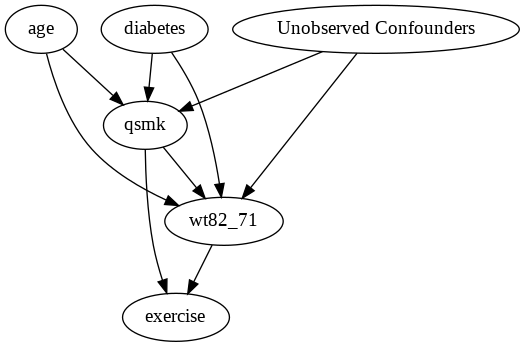

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'diabetes', 'U', 'age'}


{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: wt82_71~qsmk+diabetes+age


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                     
─────(Expectation(wt82_71|diabetes,age))
dqsmk                                   
Estimand assumption 1, Unconfoundedness: If U→qsmk and U→wt82_71 then P(wt82_71|qsmk,diabetes,age,U) = P(wt82_71|qsmk,diabetes,age)
### Estimand : 2
Estimand name: iv
No such variable found!

LinearRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                     
─────(Expectation(wt82_71|diabetes,age))
dqsmk                                   
Estimand assumption 1, Unconfoundedness: If U→qsmk and U→wt82_71 then P(wt82_71|qsmk,diabetes,age,U) = P(wt82_71|qsmk,diabetes,age)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: wt82_71~qsmk+diabetes+age
## Estimate
Value: 2.991085165842603

## Statistical Significance
p-value: <0.001

Causa

In [ ]:
from sklearn.preprocessing import Imputer

nhefs_imputed = nhefs
for i in selected:
  imputer = Imputer(missing_values="NaN", strategy="mean")
  nhefs_imputed[i] = imputer.fit_transform(nhefs[[i]])

data = {}
data['df'] = nhefs_imputed
data['treatment_name'] = 'qsmk'
data['outcome_name'] = 'wt82_71'
data['gml_graph'] = g.replace('\n', '')
data['dot_graph'] = d.replace('\n', '')

model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

model.view_model()
display(Image(filename="causal_model.png"))

identified_estimand = model.identify_effect()
print(identified_estimand)

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True)

print(estimate)
print("Causal Estimate is " + str(estimate.value))

In [ ]:
# df = data['df']
# df['Y'] = df['Y'] + np.random.normal(size=len(df)) # without noise, the variance in Y|X, Z is zero, and mcmc fails.

# cdf = CausalDataFrame(df)
# cdf.causal.do(x={'A': 1},
#               variable_types={'A': 'b', 'C': 'c', 'Y': 'b', 'S': 'b'},
#               outcome='Y',
#               method='mcmc',
#               common_causes=['C'],
#               keep_original_treatment=True,
#               proceed_when_unidentifiable=True).groupby('A').mean().plot(y='Y', kind='bar')

# cdf = CausalDataFrame(df)

# cdf_1 = cdf.causal.do(x={'A': 1},
#               variable_types={'A': 'b', 'C': 'c', 'Y': 'b', 'S': 'b'},
#               outcome='Y',
#               method='mcmc',
#               dot_graph=data['dot_graph'],
#               proceed_when_unidentifiable=True)

# cdf_0 = cdf.causal.do(x={'A': 0},
#               variable_types={'A': 'b', 'C': 'c', 'Y': 'b', 'S': 'b'},
#               outcome='Y',
#               method='mcmc',
#               dot_graph=data['dot_graph'],
#               proceed_when_unidentifiable=True,
#               use_previous_sampler=True)

# print((cdf_1['Y'] - cdf_0['Y']).mean())
# print(1.96*(cdf_1['Y'] - cdf_0['Y']).std() / np.sqrt(len(cdf)))

# cdf_do = cdf.causal.do(x={'A': 0},
#               variable_types={'A': 'b', 'C': 'c', 'Y': 'c'},
#               outcome='Y',
#               method='mcmc',
#               common_causes=['C'],
#               keep_original_treatment=True,
#               proceed_when_unidentifiable=True).groupby('A').mean().plot(y='Y', kind='bar')